# Kaggle : Home Credit Default Risk
고객이 대출을 상환할 수 있는 능력을 예측할 수 있는가?
## Description
: 많은 사람들이 부족한 신용때문에, 대출을 하는데 어려움을 겪고있습니다. 그리고 안타깝게도, 이런 사람들이 종종 신뢰할수 없는 대출기관을 이용합니다. 때문에 홈크레딧은 은행서비스를 받지못하는 사람들위해 안전한 대출서비스를 제공함으로써 금융서비스를 확대하려고 노력합니다. 이런 사람들이 좋은 대출서비스를 받게하기 위해서, Home Credit은 통신 및 거래 정보를 포함한 다양한 데이터를 사용하여 고객의 상환 능력을 예측합니다. Home Credit은 현재 이러한 예측을 위해 다양한 통계 및 머신러닝 방법을 사용하고 있지만, Kaggler가 데이터의 잠재력을 최대한 발휘할 수 있도록 도와달라고 요청하고 있습니다. 그렇게 하면 상환 능력이 있는 고객이 거부되지 않고 고객이 성공할 수 있도록 원금, 만기 및 상환 일정이 포함된 대출이 제공될것 입니다.
## Evaluation
: ROC curve

# **1. 필요한 라이브러리 불러오기**

In [68]:
import os
import gc # Garbage Collector: 메모리를 자동으로 관리해줌 
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# **2. 데이터 불러오기**

In [69]:
# 판다스의 옵션을 설정하는 방법
# pd.set_option() : 옵션 설정
# display.max_rows : Out으로 출력하는 최대 행의 개수
pd.set_option("display.max_rows", 60)
pd.set_option("display.max_columns", 100)

In [70]:
# debug가 True이면 30000행만 읽고, False면 전체데이터를 다 읽음, 하지만 다읽으면 시간이 너무 오래걸리기때문에 30000개만 읽음
debug = True
num_rows = 30000 if debug else None

In [71]:
# 나중에 사용할 파라미터 저장 
NUM_THREADS = 4
DATA_DIRECTORY = "../input/"
SUBMISSION_SUFIX = "_model2_04"

In [72]:
# 데이터 불러오기
train = pd.read_csv("/content/drive/MyDrive/캐글 데이터/home-credit-default-risk/application_train.csv", nrows = num_rows)
test = pd.read_csv("/content/drive/MyDrive/캐글 데이터/home-credit-default-risk/application_test.csv", nrows = num_rows)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

In [73]:
print(train.shape)
print(test.shape)

(30000, 122)
(30000, 121)


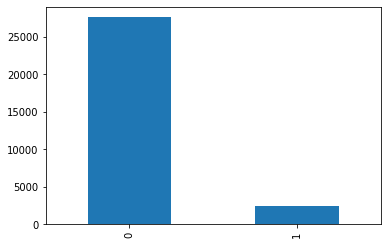

In [74]:
# 타겟데이터 분포 확인
train['TARGET'].value_counts().plot.bar()

데이터가 불균형해보입니다.

In [75]:
# 훈련셋과 테스트셋 병합
df = train.append(test)

In [76]:
del train, test;

In [77]:
#메모리 관리를 위해 사용
gc.collect()

139

# **3. 데이터 전처리**

In [78]:
df = df[df['CODE_GENDER'] != 'XNA']  # 성별에서 결측치 제거

In [79]:
# 최대 수입 : test is 4M; train has a 117M value
# 훈련셋과 테스트셋의 갭차이가 너무 큼
# 2000만원 미만의 값만 저장
df = df[df['AMT_INCOME_TOTAL'] < 20000000]  

In [80]:
# 근무일수
# 근무일수중에 365243이라는 값이 존재, 해당값은 말이안되므로 결측치로 판단
(df['DAYS_EMPLOYED'] == 365243).sum()

11120

In [81]:
# 해당 값을 결측치로 변환
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

In [82]:
# 핸드폰을 바꾼지 얼마나됬는지 일수
# 해당값들중 0 값이 존재, 마찬가지로 말이안됨
(df['DAYS_LAST_PHONE_CHANGE'] == 0).sum()

7187

In [83]:
# 해당값을 결측치로 대체
df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

# **4. Feature engineering**

In [84]:
# 예/아니오 형식의 설문조항문서들
docs = [f for f in df.columns if 'FLAG_DOC' in f]
docs

['FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

In [85]:
df[docs]

,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29996,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29997,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29998,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


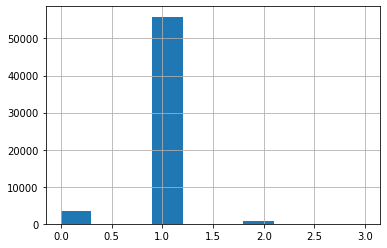

In [86]:
# 한사람이 몇번 yes를했는지 시각화
# 대부분은 한번만 예를했음을 확인할수있습니다.
df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
df['DOCUMENT_COUNT'].hist()

In [87]:
df['DOCUMENT_COUNT'].value_counts()

1    55877
0     3343
2      762
3       17
Name: DOCUMENT_COUNT, dtype: int64

대부분은 한번만 예를했음을 확인할수있습니다.

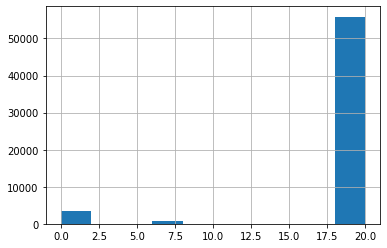

In [88]:
# 얼마나 한쪽으로 값들이 치우쳐져있는지 시각화
df[docs].kurtosis(axis=1).hist()

In [89]:
# 해당통계값을 새로운 feature에 저장
df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)

In [90]:
# 사람의나이를 총 5개의 정수로 카테고리화하는함수
def get_age_label(days_birth):
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

In [91]:
# Day_birth : 살아온 일수, 새로운 피쳐생
df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

In [92]:
# 외부소스로 만들어진 펴처들을 가지고 서로 곱해서 새로운 피쳐생성
# 해당 피쳐가 feature importance가 매우 높음
df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

In [93]:
# 외부소스의 피처에 가중치를 둠
# 2,1,3 이라는 숫자가 곱해져있는데 해당값은 여러값들을 시도해본결과 가장좋은 결과를낸 조합입니다
# 이값으로 또 새로운 피처생성
df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3

## 이렇게 새롭게 만들어내는 피처들이 의미가 있는것인가?
답은 성능에 도움이된다.

현업에서는 이러한 피처들의 설명이 있어야하기때문에 쓰기힘들다. 하지만 캐글에서는 설명이 되지않는 피처라도 성능에 도움이 되기때문에 사용한다. 따라서 최대한 많은 피처들을 만들어서 성능을 올리는것이 캐글의 목표이다


In [94]:
# 특정오류를 다음과 같이 지정해서 억제할수있습니다.
np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')

In [95]:
# eval() : string으로도 함수를 사용할 수 있게 만들어줌
# ex) eval('np.{}'.format(min))() = np.min()
# 외부소스의 대표적인 통계값들을 계산해서 새로운 피처를 생성하는 반복문 
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
    df[feature_name] = eval('np.{}'.format(function_name))(df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

In [96]:
df['EXT_SOURCES_MEAN']

0        0.161787
1        0.466757
2        0.642739
3        0.650442
4        0.322738
           ...   
29995    0.715913
29996    0.539833
29997    0.473152
29998    0.711375
29999    0.575803
Name: EXT_SOURCES_MEAN, Length: 59999, dtype: float64

In [97]:
# 도메인 지식(금융)을 활용한 피처생성 
df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

In [98]:
# 먼저 다음과 같이 5개의 그룹으로 나눕니다. 그리고 해당 그룹들과의 통계값을 확인하고자 합니다.
group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']

In [99]:
def do_median(df, group_cols, counted, agg_name):
    # 1.해당그룹과 평균피처로 이뤄어진 df을 만든다 
    # 2.해당그룹으로 gropby시켜줌
    # 3.여기에 평균값들의 중간값을 구해줌
    # 4.인덱스 새롭게 정렬
    # 5.평균피처를 중간값피처로 이름변경
    # 6.이렇게 만들어진 데이터프레임을 gp변수에 저장
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(columns={counted: agg_name})
    
    # merge() : df와 gp를 병합
    df = df.merge(gp, on=group_cols, how='left')
    # gp제거
    del gp
    gc.collect()
    return df

df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')

In [100]:
# 위의 동작과 같음
def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')

In [101]:
# 위의 동작과 같음
def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')

In [102]:
# 범주형 변수를 정수형으로 인코딩
def label_encoder(df, categorical_columns=None):
    # dtype이 'object'인 컬럼들을 리스트로 저장
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']

    # 라벨인코더에는 두가지 방식이 존재함 1.사이킷런의 라벨인코더, 2.판다스의 factorize
    # 둘중에 factorize가 더 빠르기때문에 보통 판다스의 factorize를 사용한다고 함
    # pd.factorize : 두가지가 반환됨.카테고리와 카테고리에해당하는 정수로 이루어진 배열을 반환
    # ex) array([0,1,1,0.....]), Index(['M','F'])
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])

    return df, categorical_columns

df, le_encoded_cols = label_encoder(df, None)

In [103]:
# 필요없는 피처들 드랍
def drop_application_columns(df):
    
    drop_list = [
        'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'NONLIVINGAREA_AVG',
        'FLOORSMIN_MEDI', 'LANDAREA_MODE', 'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MODE',
        'FLOORSMIN_AVG', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 'LANDAREA_MEDI',
        'COMMONAREA_MEDI', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',
        'BASEMENTAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 'ENTRANCES_MODE',
        'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MEDI',
        'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_AVG', 'HOUSETYPE_MODE',
        'FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE'
    ]

    # flag document columns들을 드랍리스트에 추가
    for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    
    df.drop(drop_list, axis=1, inplace=True)
    return df

df = drop_application_columns(df)

In [104]:
df.shape

(59999, 83)

## 중요하지 않은 피쳐들을 어떻게 선정할까?
### CASE1
|sample|target|
|:-:|:-:|
|A|1|
|B|0|
|C|1|

feature importance 매우 높음
### CASE2 : CASE1을 인위적으로 뒤집음
|sample|target|
|:-:|:-:|
|A|0|
|B|1|
|C|0|

feature importance 매우 낮음

결론 : 해당 피처는 중요한 피처이다

반대의 경우도 마찬가지이므로 해당 방법으로 필요없는 피처를 찾아낼 수 있다.

In [105]:
# bureau : 홈크레딧이 아닌 다른신용대출회사의 거래내역 파일
bureau = pd.read_csv("/content/drive/MyDrive/캐글 데이터/home-credit-default-risk/bureau.csv", nrows= num_rows)
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [106]:
# 새로운 피쳐 형성

# 크레딧 기간 및 크레딧 기간의 종료날짜 차이
bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
# 신용 대 부채의 비율 및 차이
bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']

# 원 핫 인코더

In [107]:
# 범주형 컬럼을 원핫인코딩 시켜줌
def one_hot_encoder(df, categorical_columns=None, nan_as_category=True):
    # 모든 컬럼을 리스트에 담음
    original_columns = list(df.columns)
    # 범주형인 컬럼만 리스트에 담음
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    # get_dummies로 원핫인코딩, dummy_na인자 : null값을 카테고리로 칠것인지말것인지 결정    
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    # 새로 추가된 컬럼을 리스트에 담음
    categorical_columns = [c for c in df.columns if c not in original_columns]
    return df, categorical_columns

In [108]:
bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category= False)

In [109]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_DURATION,ENDDATE_DIF,DEBT_PERCENTAGE,DEBT_CREDIT_DIFF,CREDIT_TO_ANNUITY_RATIO,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,-131,NaN,344.0,0.0,inf,91323.0,NaN,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,-20,NaN,1283.0,NaN,1.313163,53658.0,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,-16,NaN,731.0,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,-16,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,-21,NaN,1826.0,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [110]:
# 새롭게 추가된 컬럼
categorical_cols

['CREDIT_ACTIVE_Active',
 'CREDIT_ACTIVE_Bad debt',
 'CREDIT_ACTIVE_Closed',
 'CREDIT_ACTIVE_Sold',
 'CREDIT_CURRENCY_currency 1',
 'CREDIT_CURRENCY_currency 2',
 'CREDIT_CURRENCY_currency 3',
 'CREDIT_CURRENCY_currency 4',
 'CREDIT_TYPE_Another type of loan',
 'CREDIT_TYPE_Car loan',
 'CREDIT_TYPE_Consumer credit',
 'CREDIT_TYPE_Credit card',
 'CREDIT_TYPE_Loan for business development',
 'CREDIT_TYPE_Loan for working capital replenishment',
 'CREDIT_TYPE_Microloan',
 'CREDIT_TYPE_Mortgage',
 'CREDIT_TYPE_Real estate loan',
 'CREDIT_TYPE_Unknown type of loan']

In [111]:
# 대출회사의 고객state를 나타내는 컬럼이 포함되어있는 파일, ex)acitve대출중인지,closed끝났는지 등등
bb = pd.read_csv("/content/drive/MyDrive/캐글 데이터/home-credit-default-risk/bureau_balance.csv", nrows = num_rows)
# 원핫인코딩
bb, categorical_cols = one_hot_encoder(bb, nan_as_category= False)

In [112]:
categorical_cols

['STATUS_0',
 'STATUS_1',
 'STATUS_2',
 'STATUS_3',
 'STATUS_4',
 'STATUS_5',
 'STATUS_C',
 'STATUS_X']

In [113]:
# SK_ID_BUREAU컬럼을 기준으로 state의 평균값을 계산
bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()

In [114]:
# 최소, 최대, 개수 및 평균 지불기간(개월)
agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}

In [115]:
df_to_agg = bb
df_to_merge = bb_processed
prefix = ''
aggregations = agg
aggregate_by = "SK_ID_BUREAU"

In [116]:
def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    # SK_ID_BUREAU컬럼을 기준으로 min, max, mean, size 값 계산
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    # 해당 데이터프레임의 컬럼명이 다소 복잡하기때문에 새롭게 변경
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()

# 데이터프레임 병합
def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)

In [117]:
# 위에서했던 bureau파일의 모든 작업들을 함수로 작성
def get_bureau_balance(num_rows= None):
    bb = pd.read_csv("/content/drive/MyDrive/캐글 데이터/home-credit-default-risk/bureau_balance.csv", nrows= num_rows)
    bb, categorical_cols = one_hot_encoder(bb, nan_as_category= False)
    
    bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()

    agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
    bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')
    del bb; gc.collect()
    return bb_processed

bureau = bureau.merge(get_bureau_balance(num_rows), how='left', on='SK_ID_BUREAU')

In [118]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_DURATION,ENDDATE_DIF,DEBT_PERCENTAGE,DEBT_CREDIT_DIFF,CREDIT_TO_ANNUITY_RATIO,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_SIZE
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,-131,NaN,344.0,0.0,inf,91323.0,NaN,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,-20,NaN,1283.0,NaN,1.313163,53658.0,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,-16,NaN,731.0,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,-16,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,-21,NaN,1826.0,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
# 모든 status값들을 더해준 컬럼을 새로 생성
bureau['STATUS_12345'] = 0 

for i in range(1,6):
        bureau['STATUS_12345'] += bureau['STATUS_{}'.format(i)]

# aggregated by number of months in balance and merge with bureau(loan length agg)

In [124]:
features = ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM',
        'AMT_CREDIT_SUM_DEBT', 'DEBT_PERCENTAGE', 'DEBT_CREDIT_DIFF', 'STATUS_0', 'STATUS_12345']
            
# Months_balance_size는 이자가 남은 개월수를 기준으로 그룹화해 features에 있는 컬럼들의 평균값계산
agg_length = bureau.groupby("MONTHS_BALANCE_SIZE")[features].mean()

In [125]:
bureau.groupby("MONTHS_BALANCE_SIZE")[features].mean().head()

,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,DEBT_PERCENTAGE,DEBT_CREDIT_DIFF,STATUS_0,STATUS_12345
MONTHS_BALANCE_SIZE,,,,,,,,
1.0,0.0,0.0,63225.000,61878.0,1.015670,1347.000,1.000000,0.0
2.0,NaN,0.0,170712.000,176040.0,0.969734,-5328.000,1.000000,0.0
4.0,NaN,0.0,1165329.000,1140736.5,1.191588,24592.500,1.000000,0.0
5.0,0.0,0.0,711386.085,0.0,NaN,711386.085,0.466667,0.0
6.0,NaN,0.0,157095.000,101398.5,1.489501,55696.500,0.916667,0.0


In [127]:
# 피처 이름변경, 기존이름에 LL_를 붙여줌
agg_length.rename({feat: 'LL_' + feat for feat in features}, axis=1, inplace=True)

# 데이터프레임 병합
bureau = bureau.merge(agg_length, how='left', on='MONTHS_BALANCE_SIZE')

del agg_length; gc.collect()

322

## 반복해서 그룹화를 통한 피처를 만들어주는 이유?
: 지금의 목표는 궁극적으로 대출을 상환할 그룹과 상환하지 않을 두그룹으로 나누는것입니다.

이 두그룹은 각 피처들에 다양한 비율로 속해있을 것인데, 특정 피처들에서는 두그룹중 한그룹이 높은 비율로 있을 것입니다. 이처럼 한쪽으로 비율이 몰려있는 피처를 찾기위해서 더하기,평균 등 다양한 계산을 그룹핑을 통해 해주는 것입니다.(Aggregation) 따라서 그룹핑을 통한 피처생성을 반복해서 해주는 것이죠.